In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

model = Sequential()

model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

model = Sequential([base_model, model])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


94765736/94765736 [==============================] - 0s 0us/step


In [2]:
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=[0.8, 1.2],  
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30,
    fill_mode='nearest',
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    brightness_range=[0.8, 1.2],  
    channel_shift_range=50.0, 
)

train_directory = '/kaggle/input/fullyaugmentedwith0duplicatepcosdataset/data/train'

train_it = datagen.flow_from_directory(
    train_directory,
    class_mode='categorical',
    classes=['infected', 'notinfected'],
    target_size=(224, 224),
    batch_size=32,
    seed=24
)

history = model.fit(
    train_it,
    epochs=25
)

Found 2400 images belonging to 2 classes.
Epoch 1/25
75/75 [==============================] - 92s 626ms/step - loss: 0.2147 - accuracy: 0.9433
Epoch 2/25
75/75 [==============================] - 41s 545ms/step - loss: 0.0553 - accuracy: 0.9829
Epoch 3/25
75/75 [==============================] - 39s 519ms/step - loss: 0.0077 - accuracy: 0.9979
Epoch 4/25
75/75 [==============================] - 39s 523ms/step - loss: 0.0712 - accuracy: 0.9867
Epoch 5/25
75/75 [==============================] - 39s 521ms/step - loss: 0.2429 - accuracy: 0.9550
Epoch 6/25
75/75 [==============================] - 39s 518ms/step - loss: 0.2545 - accuracy: 0.9796
Epoch 7/25
75/75 [==============================] - 39s 525ms/step - loss: 0.2832 - accuracy: 0.9421
Epoch 8/25
75/75 [==============================] - 40s 521ms/step - loss: 0.0659 - accuracy: 0.9762
Epoch 9/25
75/75 [==============================] - 39s 517ms/step - loss: 0.0268 - accuracy: 0.9917
Epoch 10/25
75/75 [==============================

1/1 [==============================] - 0s 23ms/step
Testing Accuracy: 99.59%
Confusion Matrix:
[[121   1]
 [  0 122]]
Classification Report:
              precision    recall  f1-score   support

    infected       1.00      0.99      1.00       122
 notinfected       0.99      1.00      1.00       122

    accuracy                           1.00       244
   macro avg       1.00      1.00      1.00       244
weighted avg       1.00      1.00      1.00       244



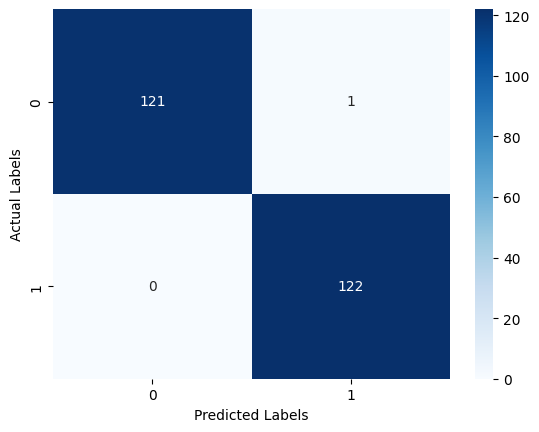

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

testt_directory = "/kaggle/input/fullyaugmentedwith0duplicatepcosdataset/data/testt"

subdirectories = [subdir for subdir in os.listdir(testt_directory) if os.path.isdir(os.path.join(testt_directory, subdir))]

correct_predictions = 0
total_predictions = 0
y_true = []
y_pred = []

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(testt_directory, subdirectory)
    image_files = os.listdir(subdirectory_path)

    for image_file in image_files:
        # Load and preprocess the image
        image_path = os.path.join(subdirectory_path, image_file)
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image)
        image = image / 255.0  

        actual_class = subdirectory

        prediction = model.predict(image.reshape(1, 224, 224, 3))
        predicted_class = "infected" if prediction[0][0] > 0.5 else "notinfected"

        is_correct = actual_class == predicted_class

        if is_correct:
            correct_predictions += 1
        total_predictions += 1
        
        y_true.append(actual_class)
        y_pred.append(predicted_class)   

testing_accuracy = correct_predictions / total_predictions

print(f"Testing Accuracy: {testing_accuracy * 100:.2f}%")

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(classification_report(y_true, y_pred))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()